<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM PEC3</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación

</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Experimentación

En la experimentación se implementará un modelo de red neuronal para realizar predicciones de accidentes o colisiones vehiculares.

## 0. Inicialización, carga de datos y utilidades

El código siguiente carga los paquetes necesarios para la práctica y lee los datos que utilizaremos para entrenar el modelo. Se define también algunas utilidades para preprocesar los datos y generar los datasets.

In [103]:
#Paquetes necesarios para la realizar la experimentación
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from numpy import argmax
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (Dense, Dropout, InputLayer)
from datetime import date, datetime, timedelta
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report #Importo el paquete necesario

%matplotlib inline

Se importa además el paquete necesario para la generación del geotash

In [2]:
#!pip install python-geohash
import Geohash

Se importan los datos requeridos para la experimentación

In [3]:
traffic_urban_ = pd.read_csv('https://data.calgary.ca/api/views/35ra-9556/rows.csv?accessType=DOWNLOAD')

Se verifica el dataset importado los campos y los valores

In [4]:
traffic_urban = traffic_urban_
traffic_urban.tail()

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,location,Count,id
24637,Southbound Deerfoot Trail approaching Anderso...,Traffic incident. Blocking the centre lane,05/21/2021 05:53:57 PM,NaN,NaN,-114.031213,50.961817,"(50.96181687721292, -114.0312133034021)",1,2021-05-21T17:53:5750.96181687721292-114.03121...
24638,Southbound Deerfoot Trail approaching Anderso...,Traffic incident. Blocking the right shoulder,05/21/2021 05:53:57 PM,NaN,NaN,-114.031216,50.961567,"(50.961567048351334, -114.03121555598563)",1,2021-05-21T17:53:5750.961567048351334-114.0312...
24639,Southbound Sarcee Trail at Signal Hill Ce SW,Traffic incident. Blocking the SB exit ramp,05/21/2021 08:10:01 PM,NaN,NaN,-114.164601,51.023316,"(51.023315823402605, -114.16460145958523)",1,2021-05-21T20:10:0151.023315823402605-114.1646...
24640,Falconridge Boulevard and Castleridge Bouleva...,Two vehicle incident. Blocking the intersection,05/21/2021 11:16:39 PM,NaN,NaN,-113.958764,51.099956,"(51.09995627679963, -113.95876397905161)",1,2021-05-21T23:16:3951.09995627679963-113.95876...
24641,Southbound Deerfoot Trail and Barlow Trail SE,Multi-vehicle incident. Blocking the right lane,05/21/2021 10:03:32 PM,NaN,NaN,-113.979820,50.943132,"(50.943131689761785, -113.97981969066628)",1,2021-05-21T22:03:3250.943131689761785-113.9798...


Se observan las columnas originales

In [5]:
traffic_urban.columns

Index(['INCIDENT INFO', 'DESCRIPTION', 'START_DT', 'MODIFIED_DT', 'QUADRANT',
       'Longitude', 'Latitude', 'location', 'Count', 'id'],
      dtype='object')

Se obtienen las columnas requeridas y el tipo de dato de cada una de ellas

In [6]:
traffic_urban['start_dt'] = pd.to_datetime(traffic_urban['START_DT'])
traffic_urban['latitude'] = pd.to_numeric(traffic_urban['Latitude'])
traffic_urban['longitude'] = pd.to_numeric(traffic_urban['Longitude'])
traffic_urban['class'] = 1
traffic_urban = traffic_urban[['start_dt','latitude','longitude','class']]

Se observan las dimensiones del dataset con los valores positivos, es decir los registros de colisiones 

In [7]:
traffic_urban.shape

(24642, 4)

Función que genera fechas desde la fecha de inicio del dataset hasta la fecha actual

In [8]:
def datetime_range(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
start = datetime(2016,12,1) #Fecha donde inician los registros del dataset
end = datetime.now() #Fecha de fin, fecha actual

lista_fechas = datetime_range(start, datetime.now().replace(hour=19) + timedelta(days=1),timedelta(hours=1))

Se verifica que las fechas generadas no coincidan con las fechas dentro del dataset

In [9]:
lista = []
for result in lista_fechas:
    result = pd.to_datetime(result)
    valor = traffic_urban.loc[traffic_urban.loc[:, 'start_dt'] != result]
    if len(valor) != 0:
        lista.append(result)

Se generan nuevos registros negativos es decir registros artificiales donde no existen colisiones

In [10]:
for result in lista:
    i = random.randrange(1,len(traffic_urban),1)
    df = pd.DataFrame([[result, traffic_urban['latitude'][i], traffic_urban['longitude'][i], 0]], columns=['start_dt', 'latitude', 'longitude','class'])
    traffic_urban = traffic_urban.append(df, ignore_index=True)

Se verifica el nuevo tamaño del dataset

In [11]:
traffic_urban.shape

(63878, 4)

In [12]:
traffic_urban['geohash'] = traffic_urban.apply(lambda x: Geohash.encode(x['latitude'],x['longitude'],precision=10), axis = 1)

In [13]:
traffic_urban.head()

,start_dt,latitude,longitude,class,geohash
0,2019-03-18 07:04:15,50.961226,-114.030831,1,c3ncvjjq9j
1,2019-03-16 12:31:13,51.067639,-114.027732,1,c3nft0xd93
2,2019-03-16 17:20:54,51.041940,-114.081524,1,c3nfk5bkgg
3,2019-03-16 17:08:21,50.970590,-114.036222,1,c3ncvncm5q
4,2019-03-16 18:00:55,50.994157,-114.039173,1,c3nfhgpnqx


In [14]:
traffic_urban = traffic_urban.set_index('start_dt')
traffic_urban['hora'] = traffic_urban.index.hour
traffic_urban['dia_fecha'] = traffic_urban.index.day
traffic_urban['dia_'] = traffic_urban.index.strftime('%A')
traffic_urban['mes'] = traffic_urban.index.month
traffic_urban['mes_'] = traffic_urban.index.strftime('%B')
traffic_urban['anio'] = traffic_urban.index.year
traffic_urban['dia'] = traffic_urban.dia_.replace({'Monday': 1,'Tuesday': 2,'Wednesday': 3,'Thursday': 4,'Friday': 5,'Saturday': 6,'Sunday': 7})

In [15]:
traffic_urban = traffic_urban.sort_values(by=['anio','mes','dia','hora'],ascending=[True,True,True,True])

In [16]:
traffic_urban.head()

,latitude,longitude,class,geohash,hora,dia_fecha,dia_,mes,mes_,anio,dia
start_dt,,,,,,,,,,,
2016-12-05 00:00:00,50.979515,-114.071686,0,c3nfh0x91n,0,5,Monday,12,December,2016,1
2016-12-12 00:00:00,50.862796,-114.034418,0,c3ncm569m2,0,12,Monday,12,December,2016,1
2016-12-19 00:00:00,51.114727,-114.155056,0,c3nff34uf7,0,19,Monday,12,December,2016,1
2016-12-26 00:00:00,51.090939,-114.094939,0,c3nfesyd71,0,26,Monday,12,December,2016,1
2016-12-05 01:00:00,51.048860,-114.019434,0,c3nfmmjt4t,1,5,Monday,12,December,2016,1


In [17]:
# Verificar valores nulos: 
traffic_urban.loc[traffic_urban["geohash"].isnull()]

,latitude,longitude,class,geohash,hora,dia_fecha,dia_,mes,mes_,anio,dia
start_dt,,,,,,,,,,,


In [18]:
# Detectar valores extraños: 
traffic_urban[traffic_urban['geohash'].isin([np.nan, np.inf, -np.inf])]

,latitude,longitude,class,geohash,hora,dia_fecha,dia_,mes,mes_,anio,dia
start_dt,,,,,,,,,,,


In [19]:
def hist(data,n_bins,xlabel,ylabel,title): 
    fig, axs = plt.subplots(1, 1, figsize =(18, 5), tight_layout = True)  
    # Remove axes splines 
    for s in ['top', 'bottom', 'left', 'right']: 
        axs.spines[s].set_visible(False)     
    # Remove x, y ticks
    axs.xaxis.set_ticks_position('none') 
    axs.yaxis.set_ticks_position('none')     
    # Add padding between axes and labels 
    axs.xaxis.set_tick_params(pad = 8) 
    axs.yaxis.set_tick_params(pad = 10)  
    # Add x, y gridlines 
    axs.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6) 
    # Creating histogram
    N, bins, patches = axs.hist(data, n_bins, density = 1, alpha = 0.7)  
    # Setting color
    fracs = ((N**(1/2))/N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    # Adding extra features    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # Show plot
    plt.show()

In [20]:
traffic_urban_positivos = traffic_urban.loc[traffic_urban.loc[:, 'class'] == 1]

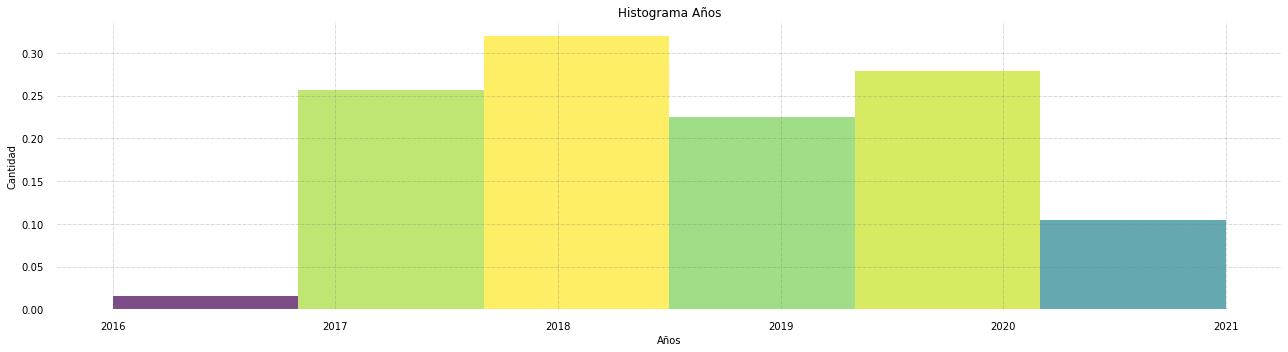

In [21]:
hist(traffic_urban_positivos['anio'],6,'Años','Cantidad','Histograma Años')

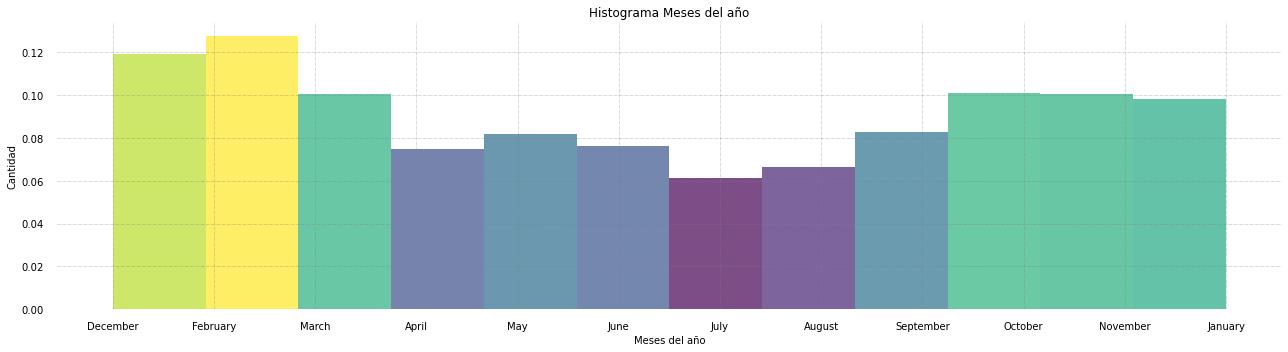

In [22]:
hist(traffic_urban_positivos['mes_'],12,'Meses del año','Cantidad','Histograma Meses del año')

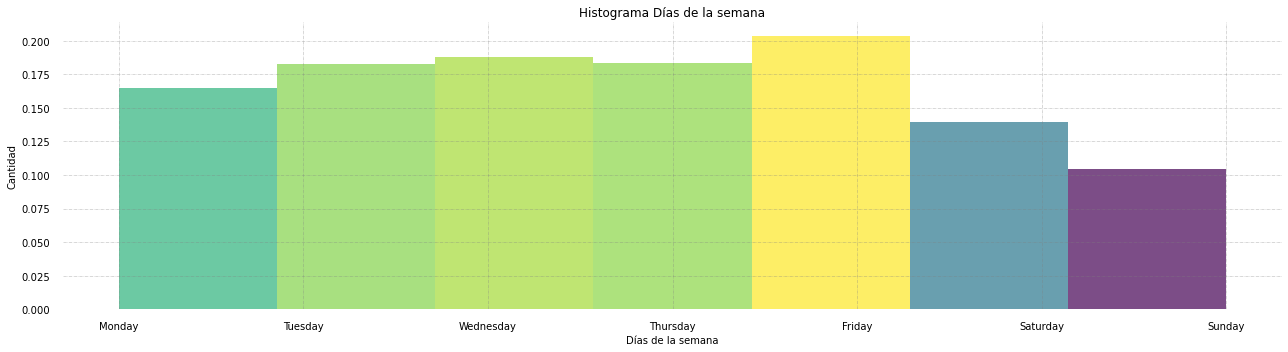

In [23]:
hist(traffic_urban_positivos['dia_'],7,'Días de la semana','Cantidad','Histograma Días de la semana')

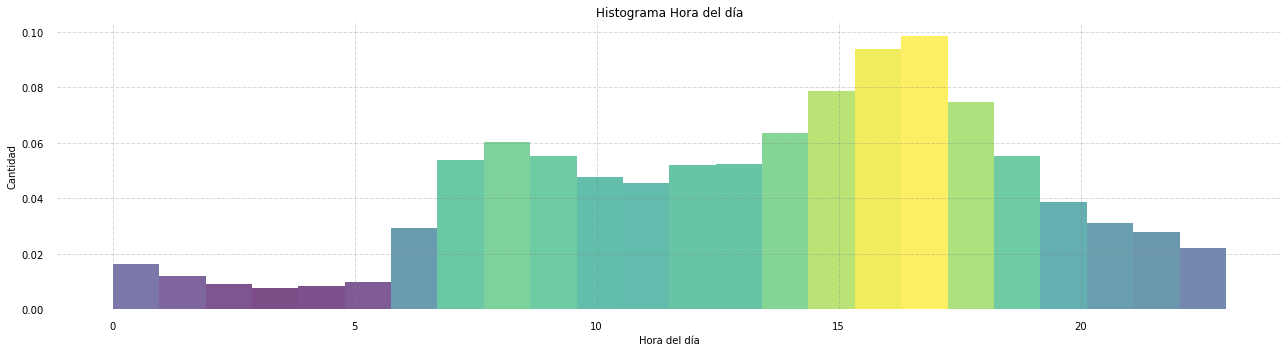

In [24]:
hist(traffic_urban_positivos['hora'],24,'Hora del día','Cantidad','Histograma Hora del día')

In [25]:
traffic_urban_2016 = traffic_urban_positivos.loc[traffic_urban_positivos.loc[:, 'anio'] == 2016]
traffic_urban_2017 = traffic_urban_positivos.loc[traffic_urban_positivos.loc[:, 'anio'] == 2017]
traffic_urban_2018 = traffic_urban_positivos.loc[traffic_urban_positivos.loc[:, 'anio'] == 2018]
traffic_urban_2019 = traffic_urban_positivos.loc[traffic_urban_positivos.loc[:, 'anio'] == 2019]
traffic_urban_2020 = traffic_urban_positivos.loc[traffic_urban_positivos.loc[:, 'anio'] == 2020]
traffic_urban_2021 = traffic_urban_positivos.loc[traffic_urban_positivos.loc[:, 'anio'] == 2021]

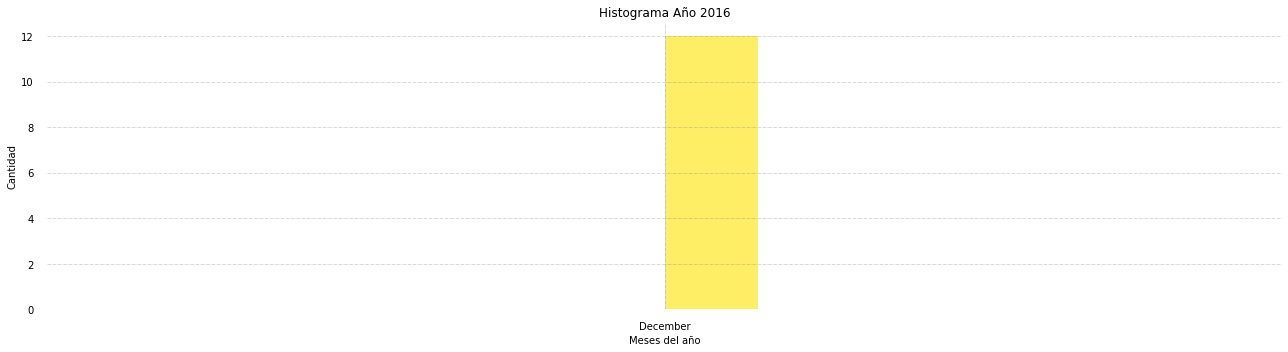

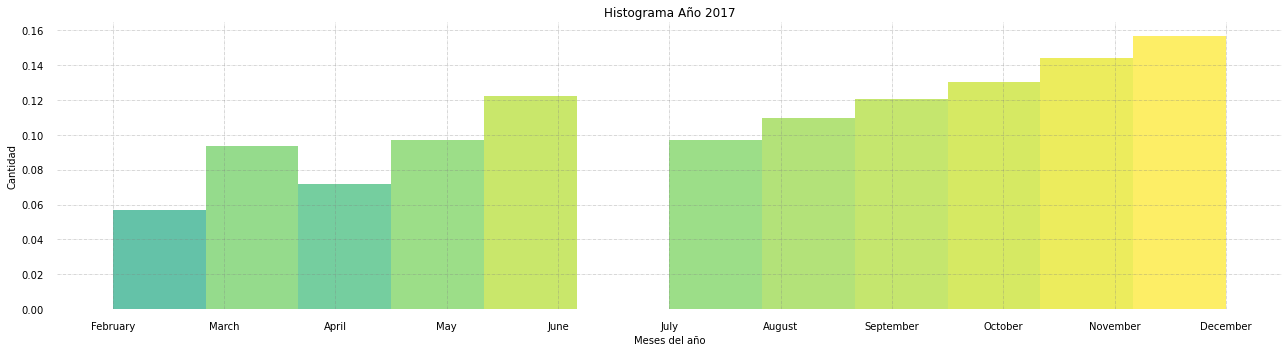

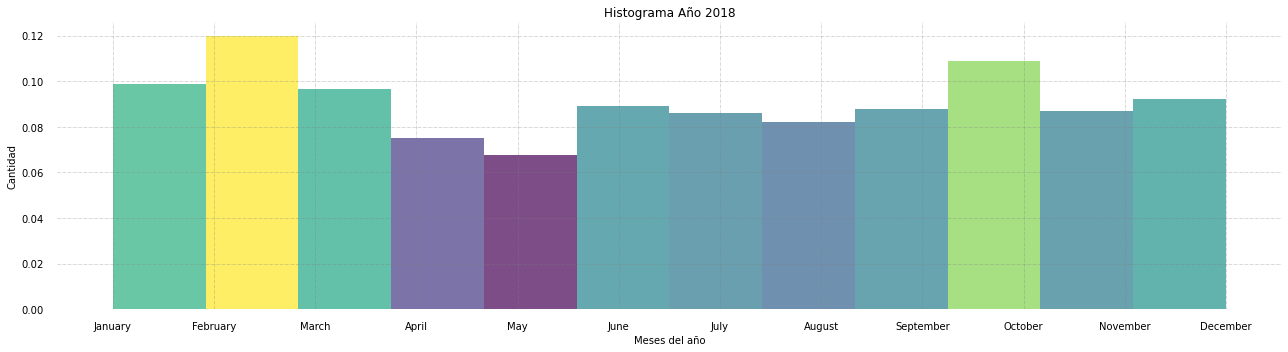

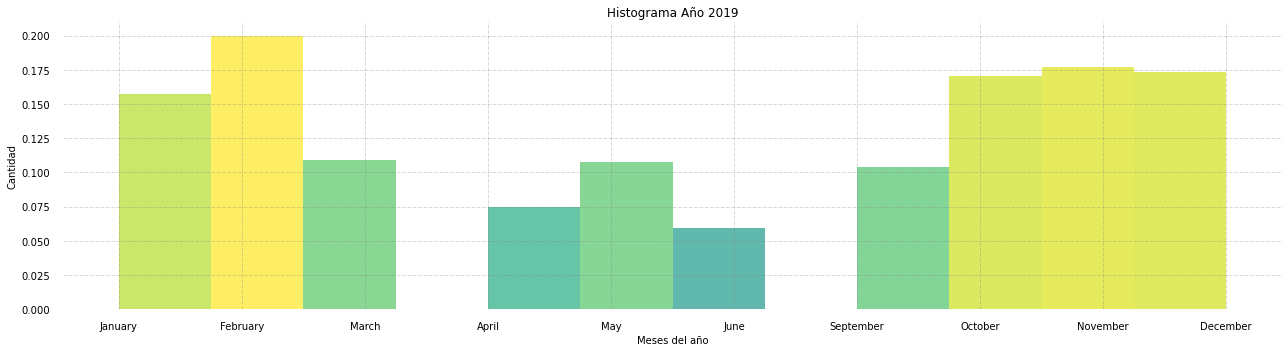

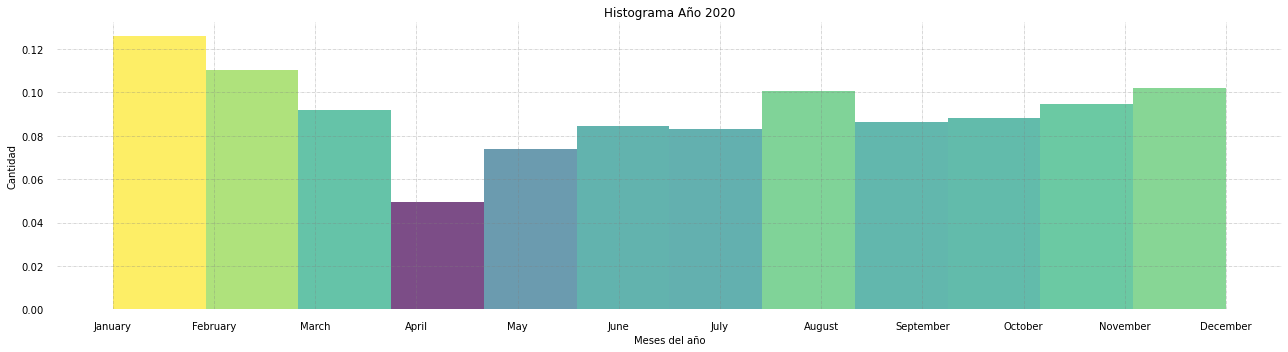

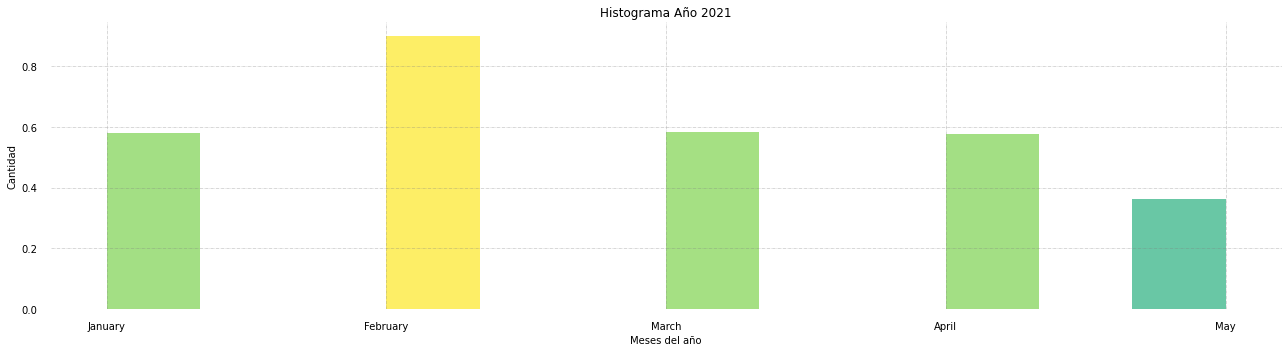

In [26]:
hist(traffic_urban_2016['mes_'],12,'Meses del año','Cantidad','Histograma Año 2016')
hist(traffic_urban_2017['mes_'],12,'Meses del año','Cantidad','Histograma Año 2017')
hist(traffic_urban_2018['mes_'],12,'Meses del año','Cantidad','Histograma Año 2018')
hist(traffic_urban_2019['mes_'],12,'Meses del año','Cantidad','Histograma Año 2019')
hist(traffic_urban_2020['mes_'],12,'Meses del año','Cantidad','Histograma Año 2020')
hist(traffic_urban_2021['mes_'],12,'Meses del año','Cantidad','Histograma Año 2021')

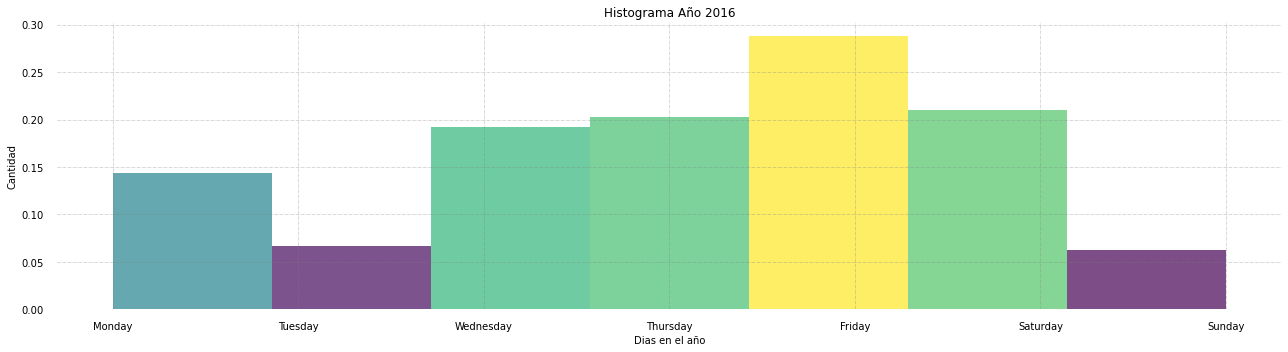

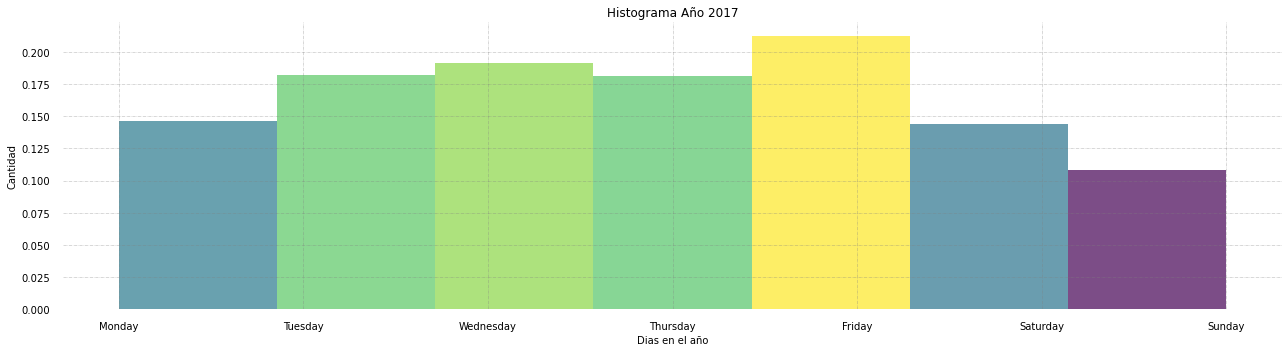

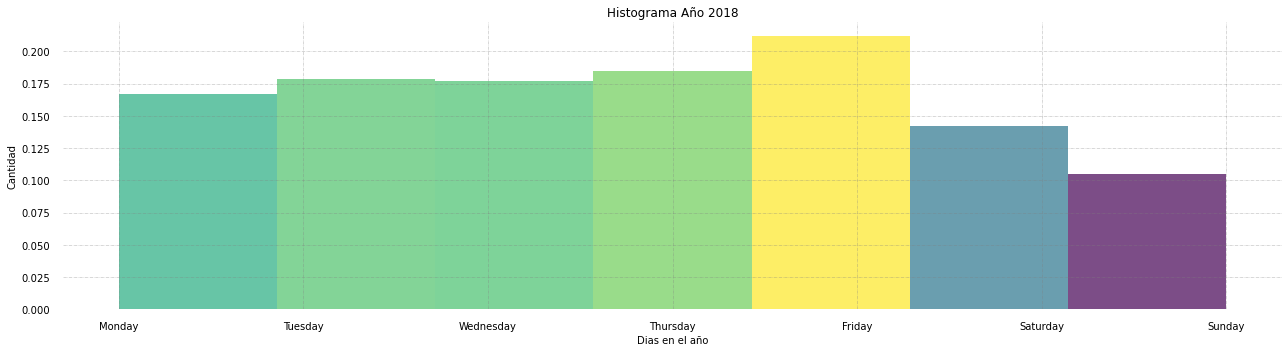

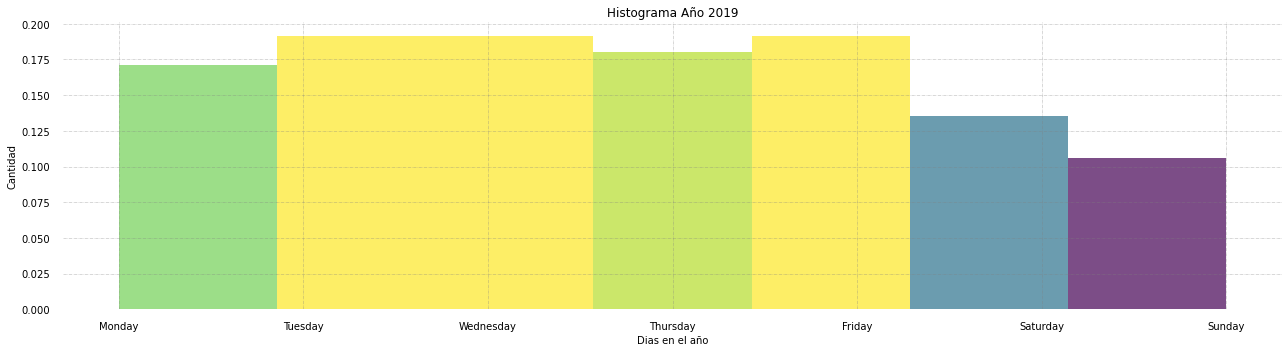

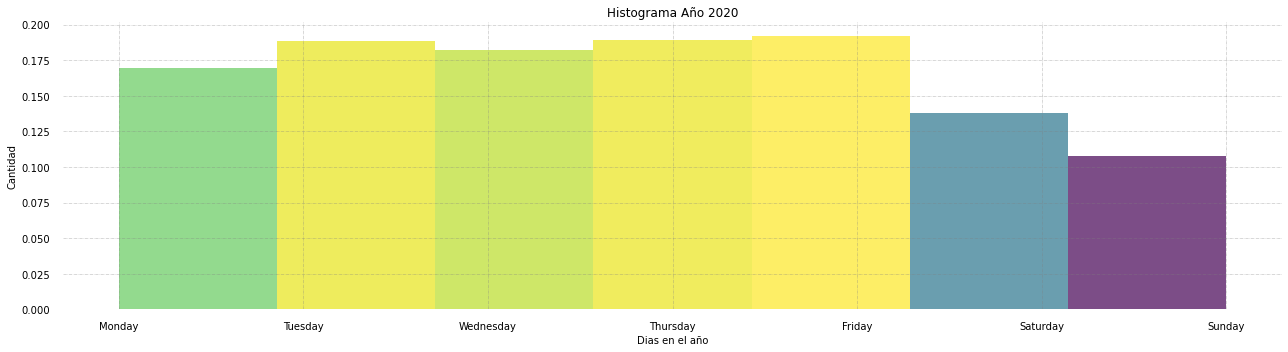

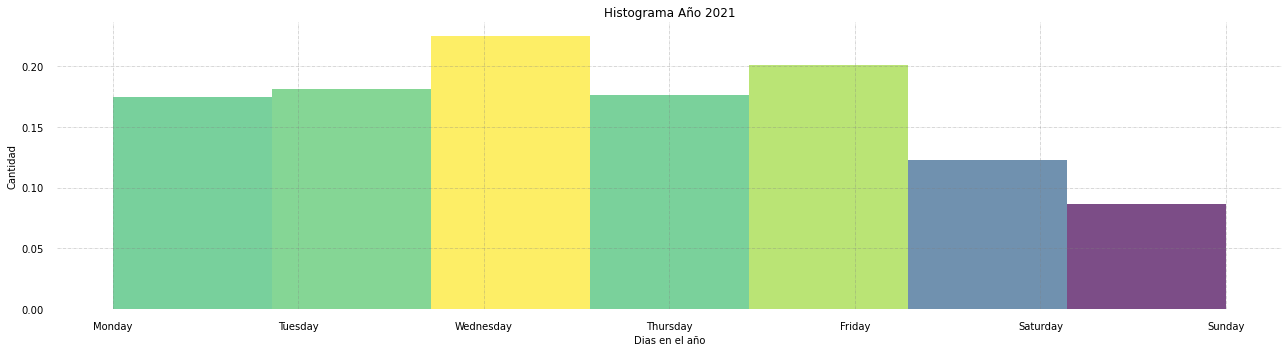

In [27]:
hist(traffic_urban_2016['dia_'],7,'Dias en el año','Cantidad','Histograma Año 2016')
hist(traffic_urban_2017['dia_'],7,'Dias en el año','Cantidad','Histograma Año 2017')
hist(traffic_urban_2018['dia_'],7,'Dias en el año','Cantidad','Histograma Año 2018')
hist(traffic_urban_2019['dia_'],7,'Dias en el año','Cantidad','Histograma Año 2019')
hist(traffic_urban_2020['dia_'],7,'Dias en el año','Cantidad','Histograma Año 2020')
hist(traffic_urban_2021['dia_'],7,'Dias en el año','Cantidad','Histograma Año 2021')

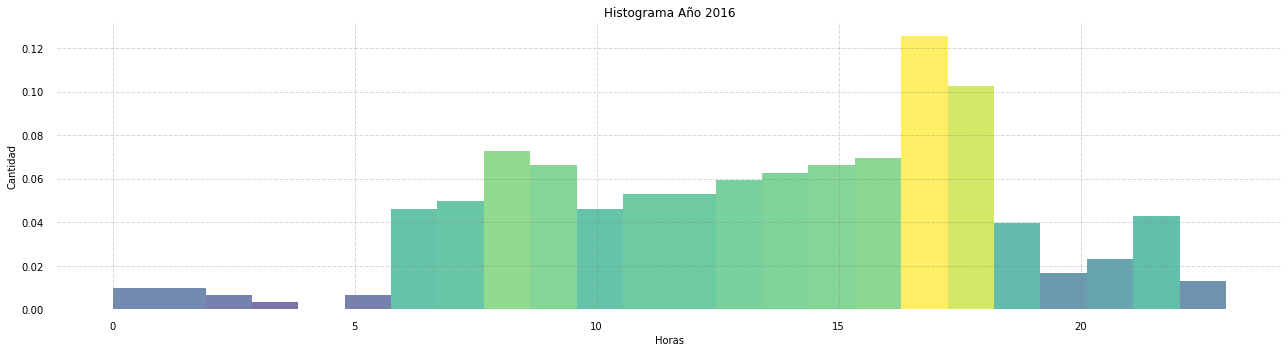

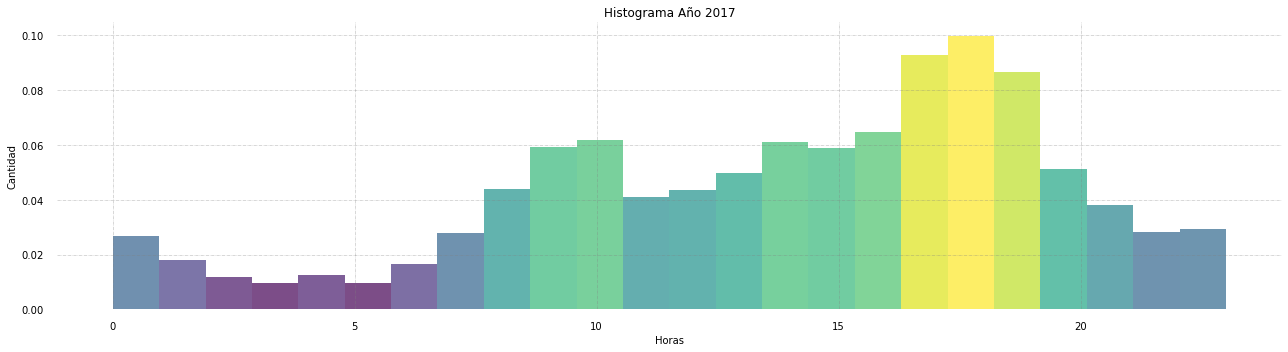

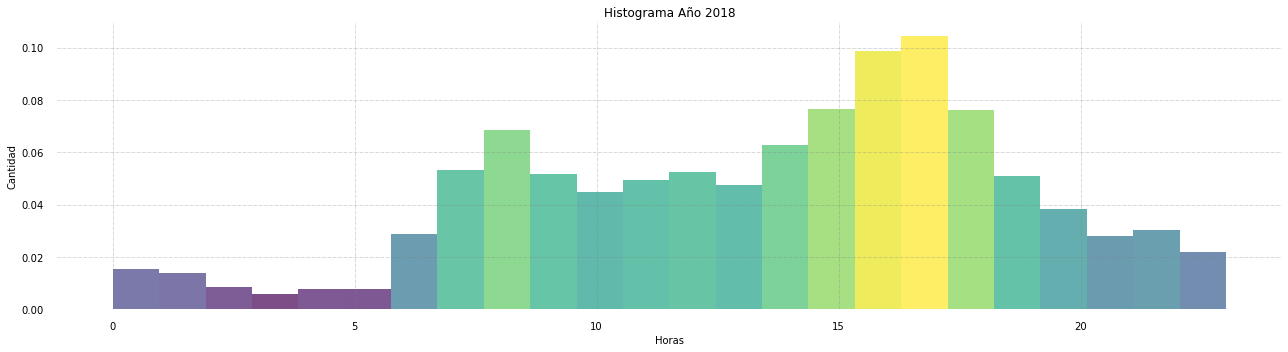

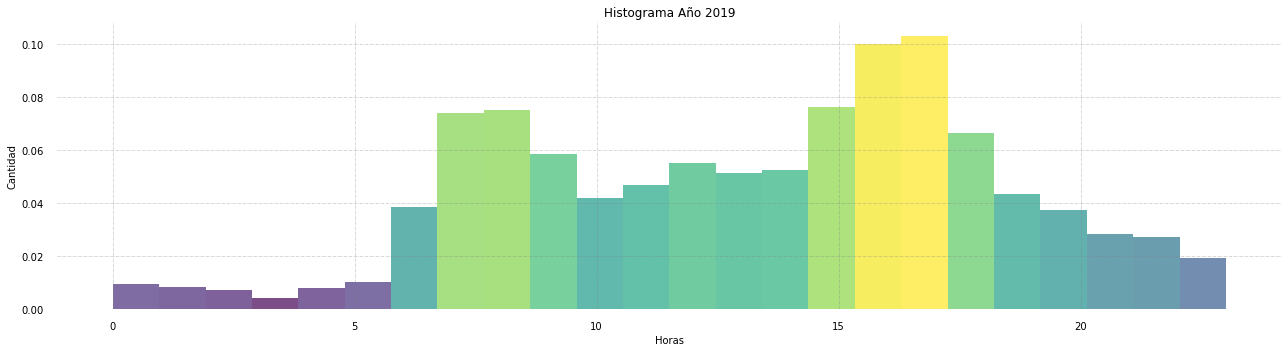

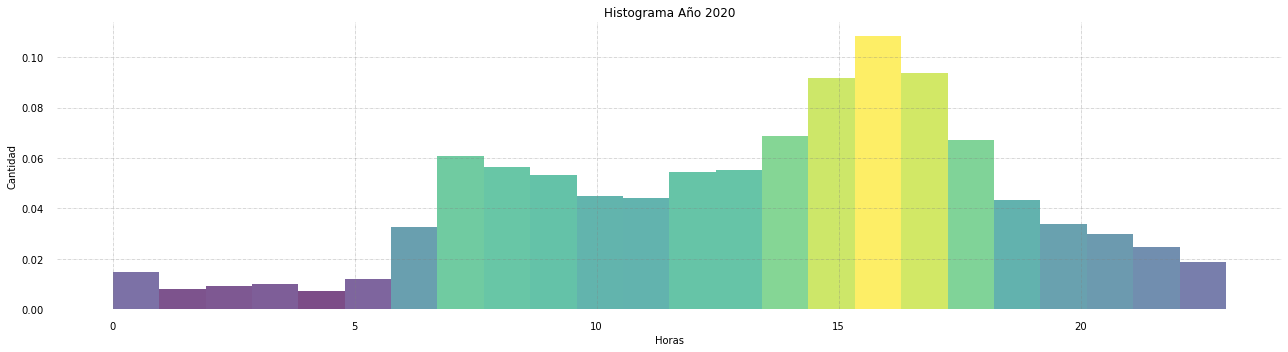

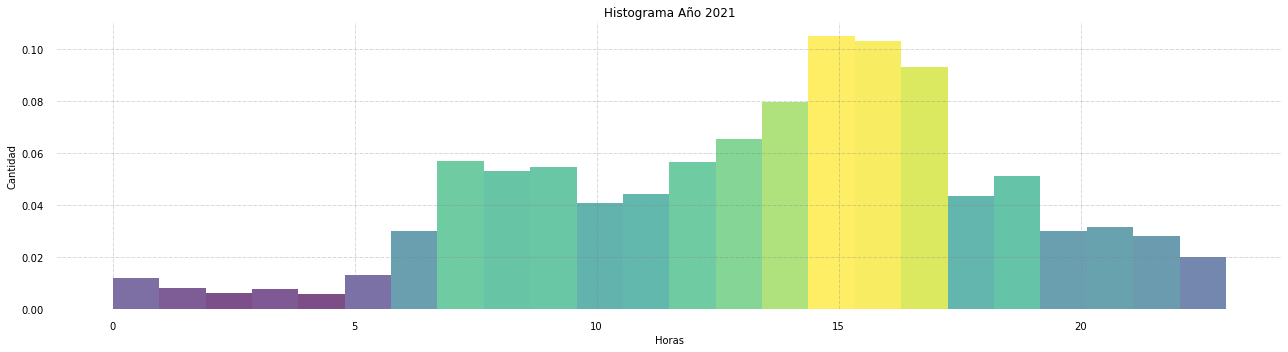

In [28]:
hist(traffic_urban_2016['hora'],24,'Horas','Cantidad','Histograma Año 2016')
hist(traffic_urban_2017['hora'],24,'Horas','Cantidad','Histograma Año 2017')
hist(traffic_urban_2018['hora'],24,'Horas','Cantidad','Histograma Año 2018')
hist(traffic_urban_2019['hora'],24,'Horas','Cantidad','Histograma Año 2019')
hist(traffic_urban_2020['hora'],24,'Horas','Cantidad','Histograma Año 2020')
hist(traffic_urban_2021['hora'],24,'Horas','Cantidad','Histograma Año 2021')

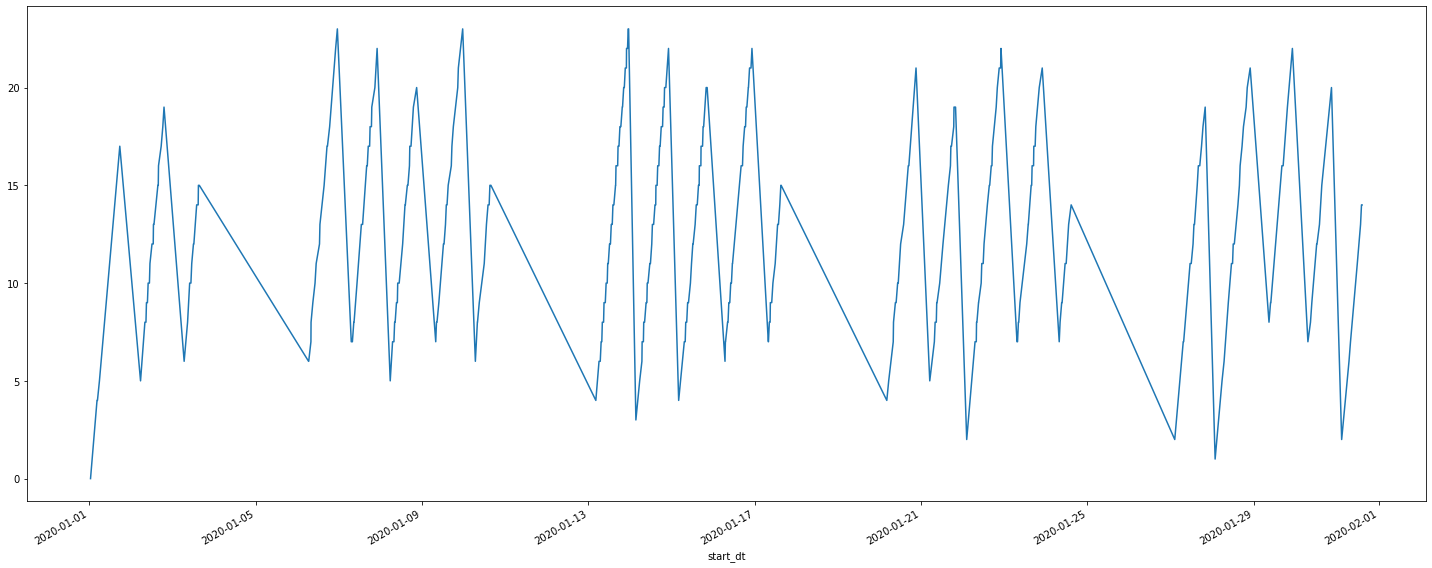

In [29]:
fig, axs = plt.subplots(1, 1, figsize =(20, 8), tight_layout = True) 
ax = pd.to_numeric(traffic_urban_2020['hora'][:500]).plot()

In [30]:
traffic_urban_2020['hora'][1110:1120]

start_dt
2020-02-14 21:52:37    21
2020-02-14 22:35:52    22
2020-02-14 22:41:31    22
2020-02-21 22:24:03    22
2020-02-21 23:31:42    23
2020-02-29 00:08:43     0
2020-02-08 00:58:04     0
2020-02-15 00:15:47     0
2020-02-22 01:24:39     1
2020-02-29 04:43:32     4
Name: hora, dtype: int64

In [31]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [32]:
traffic_urban.sort_index()
encode(traffic_urban, 'mes', 12)
encode(traffic_urban, 'dia_fecha', 365)
encode(traffic_urban, 'hora', 23)

,latitude,longitude,class,geohash,hora,dia_fecha,dia_,mes,mes_,anio,dia,mes_sin,mes_cos,dia_fecha_sin,dia_fecha_cos,hora_sin,hora_cos
start_dt,,,,,,,,,,,,,,,,,
2016-12-05 00:00:00,50.979515,-114.071686,0,c3nfh0x91n,0,5,Monday,12,December,2016,1,-2.449294e-16,1.000000,0.085965,0.996298,0.000000e+00,1.000000
2016-12-12 00:00:00,50.862796,-114.034418,0,c3ncm569m2,0,12,Monday,12,December,2016,1,-2.449294e-16,1.000000,0.205104,0.978740,0.000000e+00,1.000000
2016-12-19 00:00:00,51.114727,-114.155056,0,c3nff34uf7,0,19,Monday,12,December,2016,1,-2.449294e-16,1.000000,0.321270,0.946988,0.000000e+00,1.000000
2016-12-26 00:00:00,51.090939,-114.094939,0,c3nfesyd71,0,26,Monday,12,December,2016,1,-2.449294e-16,1.000000,0.432776,0.901502,0.000000e+00,1.000000
2016-12-05 01:00:00,51.048860,-114.019434,0,c3nfmmjt4t,1,5,Monday,12,December,2016,1,-2.449294e-16,1.000000,0.085965,0.996298,2.697968e-01,0.962917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-16 22:00:00,50.931568,-113.958801,0,c3ncwzc9zk,22,16,Sunday,5,May,2021,7,5.000000e-01,-0.866025,0.271958,0.962309,-2.697968e-01,0.962917
2021-05-16 23:03:19,50.963994,-114.058676,1,c3ncut9nb1,23,16,Sunday,5,May,2021,7,5.000000e-01,-0.866025,0.271958,0.962309,-2.449294e-16,1.000000
2021-05-02 23:00:00,51.042486,-113.981650,0,c3nfqk1051,23,2,Sunday,5,May,2021,7,5.000000e-01,-0.866025,0.034422,0.999407,-2.449294e-16,1.000000


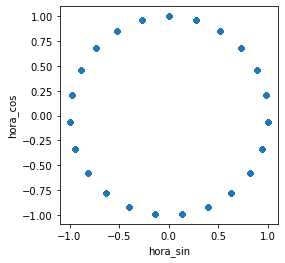

In [33]:
ax = traffic_urban.plot.scatter('hora_sin', 'hora_cos').set_aspect('equal')

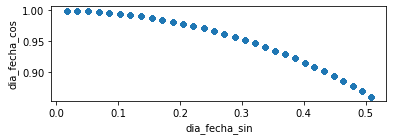

In [34]:
ax = traffic_urban.plot.scatter('dia_fecha_sin', 'dia_fecha_cos').set_aspect('equal')

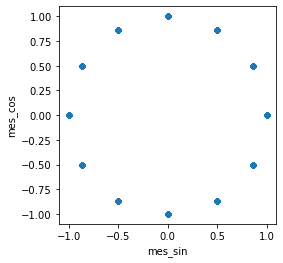

In [35]:
ax = traffic_urban.plot.scatter('mes_sin', 'mes_cos').set_aspect('equal')

In [36]:
def get_unencoded_features(data):
    return traffic_urban[['geohash', 'mes', 'dia_fecha', 'hora', 'class']]

In [37]:
traffic_urban_unencoded = get_unencoded_features(traffic_urban)
traffic_urban_unencoded.head()

,geohash,mes,dia_fecha,hora,class
start_dt,,,,,
2016-12-05 00:00:00,c3nfh0x91n,12,5,0,0
2016-12-12 00:00:00,c3ncm569m2,12,12,0,0
2016-12-19 00:00:00,c3nff34uf7,12,19,0,0
2016-12-26 00:00:00,c3nfesyd71,12,26,0,0
2016-12-05 01:00:00,c3nfmmjt4t,12,5,1,0


In [38]:
traffic_urban = pd.get_dummies(traffic_urban, columns=['geohash'], drop_first = False)

In [39]:
traffic_urban.shape

(63878, 12114)

In [40]:
def get_encoded_features(data):
    traffic_urban_encoded = traffic_urban
    return traffic_urban_encoded.drop(['latitude', 'longitude', 'hora', 'dia_fecha', 'dia_', 'mes', 'mes_', 'anio', 'dia'], axis = 'columns')

In [41]:
traffic_urban_encoded = get_encoded_features(traffic_urban)
traffic_urban_encoded.tail()

,class,mes_sin,mes_cos,dia_fecha_sin,dia_fecha_cos,hora_sin,hora_cos,geohash_92nbhbzjcb,geohash_c3nc7zp21k,geohash_c3nc90en0f,...,geohash_c3ngpsngf7,geohash_c3ngpu1v76,geohash_c3p1859nhh,geohash_c3p18e2gxc,geohash_c3p402sbcx,geohash_c3p4274v62,geohash_c3p427hucy,geohash_c3p42g1mhb,geohash_c3p42muccx,geohash_c3p42rhucu
start_dt,,,,,,,,,,,,,,,,,,,,,
2021-05-16 22:00:00,0,0.5,-0.866025,0.271958,0.962309,-2.697968e-01,0.962917,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-05-16 23:03:19,1,0.5,-0.866025,0.271958,0.962309,-2.449294e-16,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-05-02 23:00:00,0,0.5,-0.866025,0.034422,0.999407,-2.449294e-16,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-05-09 23:00:00,0,0.5,-0.866025,0.154309,0.988023,-2.449294e-16,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-05-16 23:00:00,0,0.5,-0.866025,0.271958,0.962309,-2.449294e-16,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


"We choose the default settings suggested by the authors that are 𝛼=0.001,𝛽1=0.9,𝛽2=0.999 and 𝜖=10−8. Theneural network is trained by Theano [24]. In addition, we apply dropout regularization to prevent overfitting. The final tuned network consists of three hidden layers with numberof neurons equal to 120, 160 and 200 with dropout rate of0.1 and training epoch of 600"

In [42]:
print(traffic_urban_encoded.shape)
X = traffic_urban_encoded.drop(['class'], axis = 'columns')
y = traffic_urban['class']

(63878, 12105)


In [43]:
#train, val, test: 60%, 20%, 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [44]:
print(X_train.shape)

(38326, 12104)


In [45]:
n_input = X_train.shape[1]
n_hidden1 = 120 #Número de neuronas de la primera capa FC
n_hidden2 = 160 #Número de neuronas de la segunda capa FC
n_hidden3 = 200 #Número de neuronas de la tercera capa FC
n_outputs = 1 #Número de neuronas de la capa de salida
optimizer = 'Adam' #Optimizador
epochs = 600
learning_rate =  0.001 #Velocidad de aprendizaje
probabilidad = 0.1 #Probabilidad de pérdida

model_dnn = tf.keras.Sequential([
    InputLayer(input_shape=n_input, name="input"),
    Dense(n_hidden1, activation="relu", name="hidden1"),
    Dropout(probabilidad), #Capa de pérdida
    Dense(n_hidden2, activation="relu", name="hidden2"),
    Dense(n_hidden3, activation="relu", name="hidden3"),
    Dense(n_outputs, activation="sigmoid", name="output")
])

In [46]:
model_dnn.summary() #Muestro un resumen del modelo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 120)               1452600   
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 160)               19360     
_________________________________________________________________
hidden3 (Dense)              (None, 200)               32200     
_________________________________________________________________
output (Dense)               (None, 1)                 201       
Total params: 1,504,361
Trainable params: 1,504,361
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Compilando el modelo
model_dnn.compile(loss="binary_crossentropy", optimizer=Adam(lr=learning_rate), metrics=["accuracy"])

In [48]:
tic=time.time() #Inicializo la variable de tiempo
history = model_dnn.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=1, batch_size=10) #Entreno el modelo
tiempo = time.time()-tic
print('Tiempo de procesamiento (secs): ', tiempo) #Imprimo el tiempo total de procesamiento

Epoch 1/600
3833/3833 [==============================] - 37s 8ms/step - loss: 0.6298 - accuracy: 0.6262 - val_loss: 0.6203 - val_accuracy: 0.6314
Epoch 2/600
3833/3833 [==============================] - 23s 6ms/step - loss: 0.5554 - accuracy: 0.7119 - val_loss: 0.6611 - val_accuracy: 0.6144
Epoch 3/600
3833/3833 [==============================] - 23s 6ms/step - loss: 0.4284 - accuracy: 0.8020 - val_loss: 0.7774 - val_accuracy: 0.5964
Epoch 4/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.3431 - accuracy: 0.8422 - val_loss: 0.8241 - val_accuracy: 0.5830
Epoch 5/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.2901 - accuracy: 0.8619 - val_loss: 1.0153 - val_accuracy: 0.5667
Epoch 6/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.2570 - accuracy: 0.8749 - val_loss: 1.0627 - val_accuracy: 0.5539
Epoch 7/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.2354 - accuracy: 0.8851 - val_loss: 1.0768 -

Epoch 112/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0568 - accuracy: 0.9763 - val_loss: 2.5154 - val_accuracy: 0.5521
Epoch 113/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0601 - accuracy: 0.9745 - val_loss: 2.2600 - val_accuracy: 0.5490
Epoch 114/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0604 - accuracy: 0.9745 - val_loss: 2.3295 - val_accuracy: 0.5413
Epoch 115/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0597 - accuracy: 0.9739 - val_loss: 2.3964 - val_accuracy: 0.5344
Epoch 116/600
3833/3833 [==============================] - 23s 6ms/step - loss: 0.0600 - accuracy: 0.9740 - val_loss: 2.3209 - val_accuracy: 0.5452
Epoch 117/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0563 - accuracy: 0.9764 - val_loss: 2.5070 - val_accuracy: 0.5366
Epoch 118/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0593 - accuracy: 0.9750 - val_

3833/3833 [==============================] - 23s 6ms/step - loss: 0.0459 - accuracy: 0.9812 - val_loss: 2.5769 - val_accuracy: 0.5362
Epoch 223/600
3833/3833 [==============================] - 23s 6ms/step - loss: 0.0441 - accuracy: 0.9819 - val_loss: 2.5310 - val_accuracy: 0.5438
Epoch 224/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0473 - accuracy: 0.9811 - val_loss: 2.7397 - val_accuracy: 0.5402
Epoch 225/600
3833/3833 [==============================] - 23s 6ms/step - loss: 0.0462 - accuracy: 0.9816 - val_loss: 2.8219 - val_accuracy: 0.5455
Epoch 226/600
3833/3833 [==============================] - 26s 7ms/step - loss: 0.0471 - accuracy: 0.9807 - val_loss: 2.7670 - val_accuracy: 0.5516
Epoch 227/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0471 - accuracy: 0.9800 - val_loss: 2.8240 - val_accuracy: 0.5437
Epoch 228/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0481 - accuracy: 0.9818 - val_loss: 2.3554 -

3833/3833 [==============================] - 25s 6ms/step - loss: 0.0464 - accuracy: 0.9818 - val_loss: 3.0800 - val_accuracy: 0.5528
Epoch 333/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.0465 - accuracy: 0.9808 - val_loss: 3.0342 - val_accuracy: 0.5542
Epoch 334/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0430 - accuracy: 0.9819 - val_loss: 2.7715 - val_accuracy: 0.5466
Epoch 335/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.0411 - accuracy: 0.9834 - val_loss: 3.1893 - val_accuracy: 0.5479
Epoch 336/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0414 - accuracy: 0.9838 - val_loss: 2.9234 - val_accuracy: 0.5460
Epoch 337/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.0436 - accuracy: 0.9836 - val_loss: 3.1000 - val_accuracy: 0.5520
Epoch 338/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.0427 - accuracy: 0.9833 - val_loss: 2.9291 -

3833/3833 [==============================] - 24s 6ms/step - loss: 0.0411 - accuracy: 0.9841 - val_loss: 3.1279 - val_accuracy: 0.5405
Epoch 443/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.0396 - accuracy: 0.9835 - val_loss: 3.4695 - val_accuracy: 0.5446
Epoch 444/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0415 - accuracy: 0.9846 - val_loss: 3.1599 - val_accuracy: 0.5411
Epoch 445/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.0460 - accuracy: 0.9826 - val_loss: 3.1826 - val_accuracy: 0.5477
Epoch 446/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0397 - accuracy: 0.9854 - val_loss: 3.0896 - val_accuracy: 0.5388
Epoch 447/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.0452 - accuracy: 0.9842 - val_loss: 3.0051 - val_accuracy: 0.5442
Epoch 448/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0388 - accuracy: 0.9850 - val_loss: 3.2877 -

3833/3833 [==============================] - 24s 6ms/step - loss: 0.0452 - accuracy: 0.9858 - val_loss: 3.0975 - val_accuracy: 0.5430
Epoch 553/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0383 - accuracy: 0.9856 - val_loss: 3.0275 - val_accuracy: 0.5427
Epoch 554/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0413 - accuracy: 0.9851 - val_loss: 2.9171 - val_accuracy: 0.5432
Epoch 555/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0395 - accuracy: 0.9860 - val_loss: 3.0921 - val_accuracy: 0.5369
Epoch 556/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0409 - accuracy: 0.9846 - val_loss: 2.9681 - val_accuracy: 0.5359
Epoch 557/600
3833/3833 [==============================] - 25s 6ms/step - loss: 0.0395 - accuracy: 0.9841 - val_loss: 3.6375 - val_accuracy: 0.5496
Epoch 558/600
3833/3833 [==============================] - 24s 6ms/step - loss: 0.0415 - accuracy: 0.9839 - val_loss: 3.2524 -

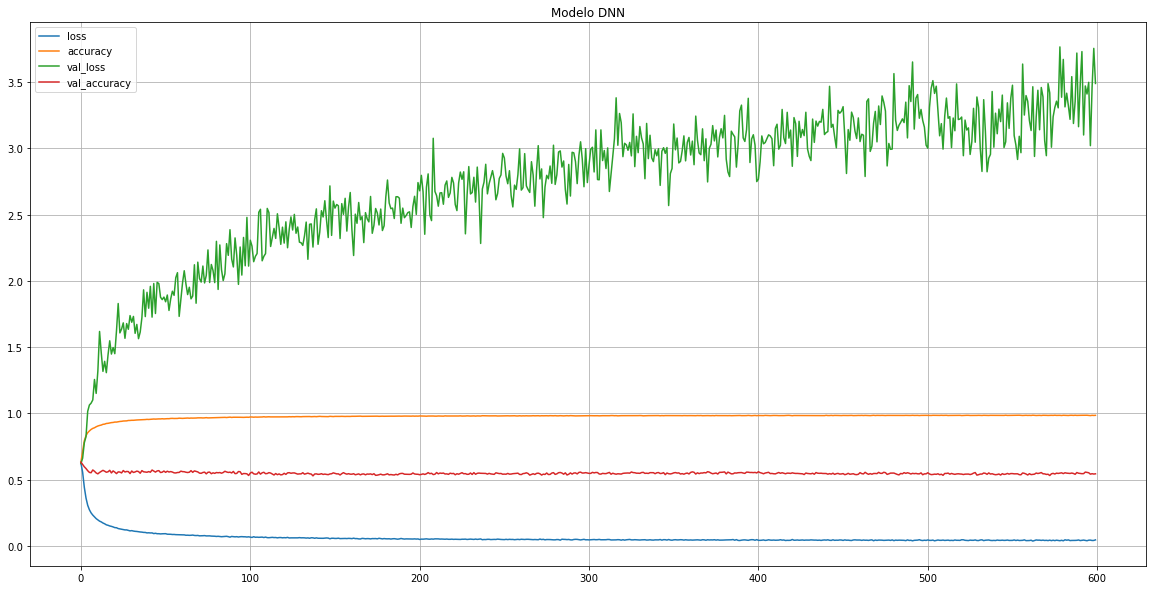

In [82]:
pd.DataFrame(history.history).plot(figsize=(20, 10)) #Tranformo a Data frame los valores del entrnamiento
plt.grid(True)
plt.gca()
plt.title('Modelo DNN') #Título del gráfico
plt.show() #Muestro los valores en el gráfico

In [51]:
test_loss, test_acc = model_dnn.evaluate(X_test, y_test)
print('Tiene una perdidad de:', test_loss)
print('Tiene una precisión de:', test_acc)

400/400 [==============================] - 2s 4ms/step - loss: 3.6537 - accuracy: 0.5672
Tiene una perdidad de: 3.653735637664795
Tiene una precisión de: 0.5671571493148804


In [59]:
n_input = X_train.shape[1]
n_hidden1 = 120 #Número de neuronas de la primera capa FC
n_hidden2 = 160 #Número de neuronas de la segunda capa FC
n_hidden3 = 200 #Número de neuronas de la tercera capa FC
n_outputs = 1 #Número de neuronas de la capa de salida
optimizer = 'Adam' #Optimizador
epochs = 100
learning_rate =  0.001 #Velocidad de aprendizaje
probabilidad = 0.1 #Probabilidad de pérdida

model_dnn2 = tf.keras.Sequential([
    InputLayer(input_shape=n_input, name="input"),
    Dense(n_hidden1, activation="relu", name="hidden1"),
    Dropout(probabilidad), #Capa de pérdida
    Dense(n_hidden2, activation="relu", name="hidden2"),
    Dense(n_hidden3, activation="relu", name="hidden3"),
    Dense(n_outputs, activation="softmax", name="output")
])

In [60]:
#Compilando el modelo
model_dnn2.compile(loss="binary_crossentropy", optimizer=Adam(lr=learning_rate), metrics=["accuracy"])

In [73]:
tic2=time.time() #Inicializo la variable de tiempo
# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=5)
history2 = model_dnn2.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=1, batch_size=10, callbacks=[es]) #Entreno el modelo
tiempo2 = time.time()-tic2
print('Tiempo de procesamiento (secs): ', tiempo) #Imprimo el tiempo total de procesamiento

Epoch 1/100
3833/3833 [==============================] - 38s 9ms/step - loss: 0.0768 - accuracy: 0.3868 - val_loss: 1.7952 - val_accuracy: 0.3871
Epoch 2/100
3833/3833 [==============================] - 33s 9ms/step - loss: 0.0749 - accuracy: 0.3868 - val_loss: 2.2374 - val_accuracy: 0.3871
Epoch 3/100
3833/3833 [==============================] - 33s 8ms/step - loss: 0.0710 - accuracy: 0.3868 - val_loss: 2.2215 - val_accuracy: 0.3871
Epoch 4/100
3833/3833 [==============================] - 34s 9ms/step - loss: 0.0721 - accuracy: 0.3868 - val_loss: 2.0616 - val_accuracy: 0.3871
Epoch 5/100
3833/3833 [==============================] - 35s 9ms/step - loss: 0.0734 - accuracy: 0.3868 - val_loss: 2.2512 - val_accuracy: 0.3871
Epoch 6/100
3833/3833 [==============================] - 33s 9ms/step - loss: 0.0701 - accuracy: 0.3868 - val_loss: 1.8791 - val_accuracy: 0.3871
Tiempo de procesamiento (secs):  14636.718796014786


In [74]:
test_loss2, test_acc2 = model_dnn2.evaluate(X_test, y_test)
print('Tiene una perdidad de:', test_loss2)
print('Tiene una precisión de:', test_acc2)

400/400 [==============================] - 2s 4ms/step - loss: 1.9146 - accuracy: 0.3813
Tiene una perdidad de: 1.9146448373794556
Tiene una precisión de: 0.38134002685546875


In [96]:
y_pred = model_dnn.predict(X_test).round()
y_pred

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [97]:
print(classification_report(y_test, y_pred))  #Imprimo el reporte del rpimer modelo

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      7904
           1       0.43      0.41      0.42      4872

    accuracy                           0.57     12776
   macro avg       0.54      0.54      0.54     12776
weighted avg       0.56      0.57      0.56     12776



In [106]:
confusion_matrix= confusion_matrix(y_test, y_pred)  

In [107]:
def plot_confusion_matrix(cm, normalize=False, title="Matriz de confusión", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("Clases verdaderas")
    plt.xlabel("Clases predichas") 

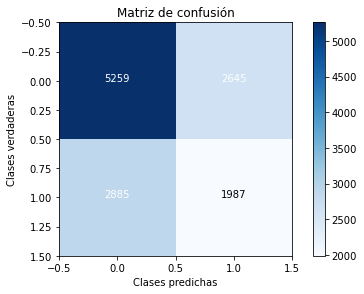

In [108]:
plot_confusion_matrix(confusion_matrix)

In [53]:
n_input = X_train.shape[1]
n_hidden1 = 50 #Número de neuronas de la primera capa FC
n_hidden2 = 50 #Número de neuronas de la segunda capa FC
n_hidden3 = 50 #Número de neuronas de la tercera capa FC
n_outputs = 1 #Número de neuronas de la capa de salida
optimizer = 'Adam' #Optimizador
dropout_rate = 0.1 #Probabilidad de pérdida
epochs = 600
learning_rate =  0.001 #Velocidad de aprendizaje
probabilidad = 0.1 #Probabilidad de pérdida

model_simple = tf.keras.Sequential([
    InputLayer(input_shape=n_input, name="input"),
    Dense(n_hidden1, activation="relu", name="hidden1"),
    Dropout(probabilidad), #Capa de pérdida
    Dense(n_hidden2, activation="relu", name="hidden2"),
    Dense(n_hidden3, activation="relu", name="hidden3"),
    Dense(n_outputs, activation="sigmoid", name="output")
])

In [54]:
model_simple.summary() #Muestro un resumen del modelo

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 50)                605250    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
hidden2 (Dense)              (None, 50)                2550      
_________________________________________________________________
hidden3 (Dense)              (None, 50)                2550      
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 610,401
Trainable params: 610,401
Non-trainable params: 0
_________________________________________________________________


In [55]:
#Compilando el modelo
model_simple.compile(loss="binary_crossentropy", optimizer=Adam(lr=learning_rate), metrics=["accuracy"])

In [56]:
tic_=time.time() #Inicializo la variable de tiempo
history_ = model_simple.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=1,batch_size=10) #Entreno el modelo
tiempo_ = time.time()-tic_
print('Tiempo de procesamiento (secs): ', tiempo_) #Imprimo el tiempo total de procesamiento

Epoch 1/600
3833/3833 [==============================] - 27s 4ms/step - loss: 0.6308 - accuracy: 0.6263 - val_loss: 0.6189 - val_accuracy: 0.6363
Epoch 2/600
3833/3833 [==============================] - 16s 4ms/step - loss: 0.5651 - accuracy: 0.6990 - val_loss: 0.6527 - val_accuracy: 0.6127
Epoch 3/600
3833/3833 [==============================] - 15s 4ms/step - loss: 0.4544 - accuracy: 0.7899 - val_loss: 0.7471 - val_accuracy: 0.6004
Epoch 4/600
3833/3833 [==============================] - 15s 4ms/step - loss: 0.3758 - accuracy: 0.8295 - val_loss: 0.8055 - val_accuracy: 0.5969
Epoch 5/600
3833/3833 [==============================] - 16s 4ms/step - loss: 0.3250 - accuracy: 0.8499 - val_loss: 0.8977 - val_accuracy: 0.5841
Epoch 6/600
3833/3833 [==============================] - 17s 4ms/step - loss: 0.2884 - accuracy: 0.8648 - val_loss: 1.0030 - val_accuracy: 0.5832
Epoch 7/600
3833/3833 [==============================] - 16s 4ms/step - loss: 0.2639 - accuracy: 0.8731 - val_loss: 1.0305 -

Epoch 57/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.1086 - accuracy: 0.9505 - val_loss: 1.8256 - val_accuracy: 0.5579
Epoch 58/600
3833/3833 [==============================] - 13s 4ms/step - loss: 0.1027 - accuracy: 0.9533 - val_loss: 1.8164 - val_accuracy: 0.5569
Epoch 59/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.1072 - accuracy: 0.9515 - val_loss: 1.9363 - val_accuracy: 0.5695
Epoch 60/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.1068 - accuracy: 0.9499 - val_loss: 1.7842 - val_accuracy: 0.5626
Epoch 61/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.1062 - accuracy: 0.9517 - val_loss: 1.8913 - val_accuracy: 0.5700
Epoch 62/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.1046 - accuracy: 0.9526 - val_loss: 1.9193 - val_accuracy: 0.5644
Epoch 63/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.1009 - accuracy: 0.9527 - val_loss: 1

3833/3833 [==============================] - 13s 3ms/step - loss: 0.0849 - accuracy: 0.9615 - val_loss: 1.9703 - val_accuracy: 0.5671
Epoch 168/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0828 - accuracy: 0.9628 - val_loss: 1.9330 - val_accuracy: 0.5663
Epoch 169/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0819 - accuracy: 0.9649 - val_loss: 1.9285 - val_accuracy: 0.5665
Epoch 170/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0827 - accuracy: 0.9644 - val_loss: 1.9075 - val_accuracy: 0.5672
Epoch 171/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0817 - accuracy: 0.9643 - val_loss: 1.9665 - val_accuracy: 0.5673
Epoch 172/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0835 - accuracy: 0.9627 - val_loss: 1.9187 - val_accuracy: 0.5783
Epoch 173/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0812 - accuracy: 0.9647 - val_loss: 1.8972 -

3833/3833 [==============================] - 13s 3ms/step - loss: 0.0781 - accuracy: 0.9668 - val_loss: 2.1319 - val_accuracy: 0.5826
Epoch 278/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0733 - accuracy: 0.9683 - val_loss: 2.0240 - val_accuracy: 0.5721
Epoch 279/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0750 - accuracy: 0.9687 - val_loss: 2.0217 - val_accuracy: 0.5794
Epoch 280/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0776 - accuracy: 0.9677 - val_loss: 2.0290 - val_accuracy: 0.5882
Epoch 281/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0685 - accuracy: 0.9702 - val_loss: 2.1477 - val_accuracy: 0.5822
Epoch 282/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0746 - accuracy: 0.9677 - val_loss: 2.1025 - val_accuracy: 0.5736
Epoch 283/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0761 - accuracy: 0.9679 - val_loss: 2.0824 -

3833/3833 [==============================] - 13s 3ms/step - loss: 0.0718 - accuracy: 0.9709 - val_loss: 2.0570 - val_accuracy: 0.5848
Epoch 388/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0718 - accuracy: 0.9695 - val_loss: 2.1282 - val_accuracy: 0.5898
Epoch 389/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0719 - accuracy: 0.9699 - val_loss: 1.9793 - val_accuracy: 0.5697
Epoch 390/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0699 - accuracy: 0.9708 - val_loss: 2.0434 - val_accuracy: 0.5874
Epoch 391/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0699 - accuracy: 0.9697 - val_loss: 2.0588 - val_accuracy: 0.5799
Epoch 392/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0727 - accuracy: 0.9706 - val_loss: 2.0668 - val_accuracy: 0.5805
Epoch 393/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0726 - accuracy: 0.9694 - val_loss: 2.1234 -

3833/3833 [==============================] - 13s 3ms/step - loss: 0.0697 - accuracy: 0.9711 - val_loss: 2.0356 - val_accuracy: 0.5864
Epoch 498/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0718 - accuracy: 0.9709 - val_loss: 1.9272 - val_accuracy: 0.5852
Epoch 499/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0655 - accuracy: 0.9726 - val_loss: 2.0778 - val_accuracy: 0.5844
Epoch 500/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0662 - accuracy: 0.9722 - val_loss: 2.0566 - val_accuracy: 0.5858
Epoch 501/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0673 - accuracy: 0.9732 - val_loss: 2.0064 - val_accuracy: 0.5809
Epoch 502/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0664 - accuracy: 0.9738 - val_loss: 2.0265 - val_accuracy: 0.5774
Epoch 503/600
3833/3833 [==============================] - 13s 3ms/step - loss: 0.0687 - accuracy: 0.9720 - val_loss: 2.0082 -

In [110]:
test_loss_, test_acc_ = model_simple.evaluate(X_test, y_test)
print('Tiene una perdidad de:', test_loss_)
print('Tiene una precisión de:', test_acc_)

400/400 [==============================] - 2s 3ms/step - loss: 2.0548 - accuracy: 0.5957
Tiene una perdidad de: 2.054790496826172
Tiene una precisión de: 0.5957263708114624


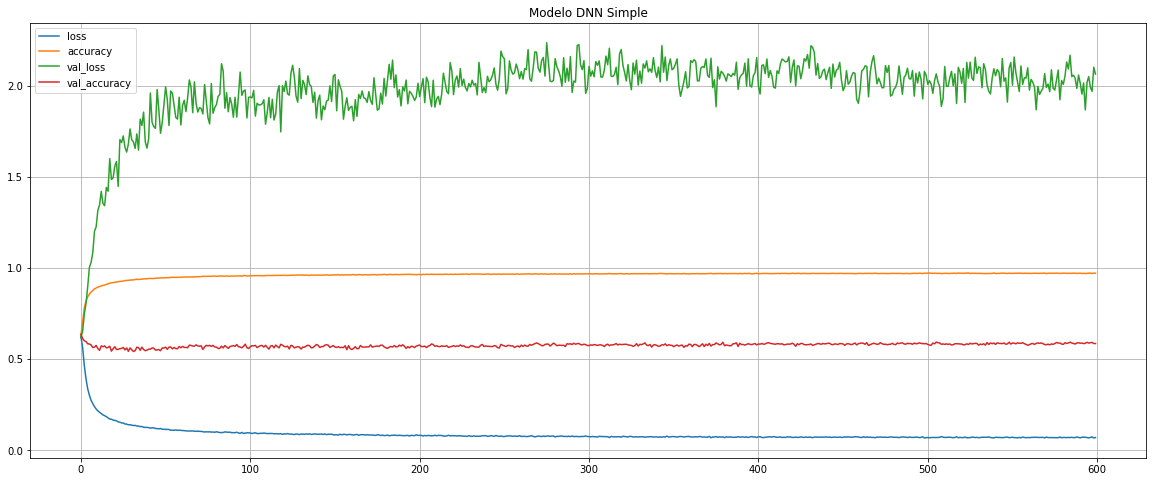

In [111]:
pd.DataFrame(history_.history).plot(figsize=(20, 8)) #Tranformo a Data frame los valores del entrnamiento
plt.grid(True)
plt.gca()
plt.title('Modelo DNN Simple') #Título del gráfico
plt.show() #Muestro los valores en el gráfico

In [99]:
y_pred_ = model_simple.predict(X_test).round()
y_pred_

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [100]:
print(classification_report(y_test, y_pred_))  

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      7904
           1       0.47      0.45      0.46      4872

    accuracy                           0.60     12776
   macro avg       0.57      0.57      0.57     12776
weighted avg       0.59      0.60      0.59     12776



In [101]:
confusion_matrix_= confusion_matrix(y_test, y_pred_)  

Matriz de confusión, sin normalización


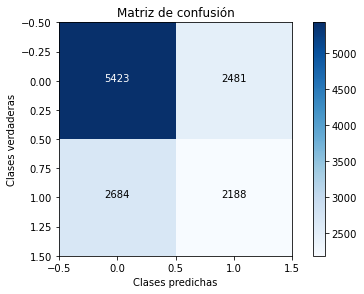

In [102]:
plot_confusion_matrix(confusion_matrix_)